# Feature Selection for Stock Return Prediction

## Objective
Reduce 32 features to optimal 15 features to:
- Reduce noise and overfitting
- Improve model generalization
- Decrease training time
- Maintain or improve prediction performance

## Feature Selection Methods
1. **Random Forest Feature Importance**
2. **Permutation Importance**
3. **Correlation Analysis** (remove redundant features)
4. **SHAP Values** (interpretable feature importance)
5. **Recursive Feature Elimination (RFE)**
6. **L1 Regularization (Lasso)**
7. **Mutual Information**

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import warnings
from typing import Tuple, List
import time

# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import RFE, mutual_info_regression, mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score

# SHAP for interpretability (install with: uv add shap)
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("WARNING: SHAP not installed. Run 'uv add shap' to enable SHAP analysis.")
    SHAP_AVAILABLE = False

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.keras

warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

2025-11-14 22:41:37.653924: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Configuration
DATA_DIR = Path('data/processed/stock_data')
MLFLOW_EXPERIMENT_NAME = 'stock-feature-selection'
WINDOW_SIZE = 60
HORIZON = 7
TEST_STOCK_RATIO = 0.2
TARGET_N_FEATURES = 15

FEATURE_NAMES = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'OI',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50',
    'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Hist',
    'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower',
    'Volume_SMA_20', 'Volume_Ratio',
    'Daily_Return', 'Price_Range', 'Price_Change',
    'Return_3d', 'Return_5d', 'Return_10d', 'Log_Return',
    'Volatility_5d', 'Volatility_20d', 'Momentum_10d', 'Momentum_20d'
]

print(f"Total features: {len(FEATURE_NAMES)}")
print(f"Target features: {TARGET_N_FEATURES}")

Total features: 32
Target features: 15


## 1. Data Loading and Preprocessing

In [3]:
def add_return_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add return-based features to dataframe."""
    df = df.copy()
    df['Return_3d'] = df['Close'].pct_change(3) * 100
    df['Return_5d'] = df['Close'].pct_change(5) * 100
    df['Return_10d'] = df['Close'].pct_change(10) * 100
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1)) * 100
    df['Volatility_5d'] = df['Daily_Return'].rolling(5).std()
    df['Volatility_20d'] = df['Daily_Return'].rolling(20).std()
    df['Momentum_10d'] = df['Close'] - df['Close'].shift(10)
    df['Momentum_20d'] = df['Close'] - df['Close'].shift(20)
    return df.dropna()


def create_sequences_with_returns(df: pd.DataFrame, window_size: int, horizon: int) -> Tuple:
    """Create sequences for time series prediction."""
    X, y_return, y_direction = [], [], []
    
    for i in range(len(df) - window_size - horizon):
        X.append(df[FEATURE_NAMES].iloc[i:i+window_size].values)
        
        current_price = df['Close'].iloc[i+window_size-1]
        future_price = df['Close'].iloc[i+window_size+horizon-1]
        return_pct = ((future_price - current_price) / current_price) * 100
        
        y_return.append(return_pct)
        y_direction.append(1 if return_pct > 0 else 0)
    
    return np.array(X), np.array(y_return), np.array(y_direction)


def load_and_prepare_data():
    """Load all stock data and prepare train/test sets."""
    csv_files = sorted(glob.glob(str(DATA_DIR / "*_historical.csv")))
    print(f"Found {len(csv_files)} stock files")
    
    all_stocks = []
    for file_path in csv_files:
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)
        df = add_return_features(df)
        
        if len(df) > WINDOW_SIZE + HORIZON:
            symbol = Path(file_path).stem.replace('_historical', '')
            all_stocks.append((symbol, df))
    
    print(f"Loaded {len(all_stocks)} stocks with sufficient data")
    
    # Split stocks
    np.random.shuffle(all_stocks)
    split_idx = int(len(all_stocks) * (1 - TEST_STOCK_RATIO))
    train_stocks = all_stocks[:split_idx]
    test_stocks = all_stocks[split_idx:]
    
    # Create sequences
    X_train, y_return_train, y_dir_train = [], [], []
    X_test, y_return_test, y_dir_test = [], [], []
    
    for symbol, df in train_stocks:
        X, y_ret, y_dir = create_sequences_with_returns(df, WINDOW_SIZE, HORIZON)
        X_train.append(X)
        y_return_train.append(y_ret)
        y_dir_train.append(y_dir)
    
    for symbol, df in test_stocks:
        X, y_ret, y_dir = create_sequences_with_returns(df, WINDOW_SIZE, HORIZON)
        X_test.append(X)
        y_return_test.append(y_ret)
        y_dir_test.append(y_dir)
    
    X_train = np.concatenate(X_train)
    y_return_train = np.concatenate(y_return_train)
    y_dir_train = np.concatenate(y_dir_train)
    
    X_test = np.concatenate(X_test)
    y_return_test = np.concatenate(y_return_test)
    y_dir_test = np.concatenate(y_dir_test)
    
    print(f"\nTrain shape: {X_train.shape}")
    print(f"Test shape: {X_test.shape}")
    
    return X_train, y_return_train, y_dir_train, X_test, y_return_test, y_dir_test

In [4]:
# Load data
X_train, y_return_train, y_dir_train, X_test, y_return_test, y_dir_test = load_and_prepare_data()

# Feature scaling
scaler = StandardScaler()
n_samples_train, n_timesteps, n_features = X_train.shape
n_samples_test = X_test.shape[0]

X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(n_samples_train, n_timesteps, n_features)
X_test_scaled = scaler.transform(X_test.reshape(-1, n_features)).reshape(n_samples_test, n_timesteps, n_features)

# Flatten for traditional ML models
X_train_flat = X_train_scaled.reshape(n_samples_train, -1)
X_test_flat = X_test_scaled.reshape(n_samples_test, -1)

print(f"\nFlattened train shape: {X_train_flat.shape}")
print(f"Flattened test shape: {X_test_flat.shape}")

Found 98 stock files
Loaded 98 stocks with sufficient data

Train shape: (29640, 60, 32)
Test shape: (7600, 60, 32)

Flattened train shape: (29640, 1920)
Flattened test shape: (7600, 1920)


## 2. Feature Importance Analysis

### 2.1 Random Forest Feature Importance

In [5]:
print("Training Random Forest for feature importance...")

# Use last timestep features for simplicity
X_train_last = X_train_scaled[:, -1, :]
X_test_last = X_test_scaled[:, -1, :]

# Train RF for regression (return prediction)
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_reg.fit(X_train_last, y_return_train)

# Train RF for classification (direction prediction)
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_last, y_dir_train)

# Feature importance
rf_importance_reg = pd.DataFrame({
    'Feature': FEATURE_NAMES,
    'Importance': rf_reg.feature_importances_
}).sort_values('Importance', ascending=False)

rf_importance_clf = pd.DataFrame({
    'Feature': FEATURE_NAMES,
    'Importance': rf_clf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Features (Random Forest - Return Prediction):")
print(rf_importance_reg.head(15))

print("\nTop 15 Features (Random Forest - Direction Prediction):")
print(rf_importance_clf.head(15))

Training Random Forest for feature importance...

Top 15 Features (Random Forest - Return Prediction):
           Feature  Importance
25       Return_5d    0.088102
29  Volatility_20d    0.081350
28   Volatility_5d    0.079572
19   Volume_SMA_20    0.071854
26      Return_10d    0.054534
13     MACD_Signal    0.052466
24       Return_3d    0.047285
14       MACD_Hist    0.043260
9           SMA_50    0.042621
12            MACD    0.039486
31    Momentum_20d    0.039094
20    Volume_Ratio    0.033305
18        BB_Lower    0.032185
15             RSI    0.028400
4           Volume    0.026427

Top 15 Features (Random Forest - Direction Prediction):
           Feature  Importance
14       MACD_Hist    0.054110
29  Volatility_20d    0.053654
19   Volume_SMA_20    0.048042
25       Return_5d    0.046421
28   Volatility_5d    0.043272
30    Momentum_10d    0.043184
26      Return_10d    0.043058
13     MACD_Signal    0.038026
9           SMA_50    0.037632
12            MACD    0.037429
15 

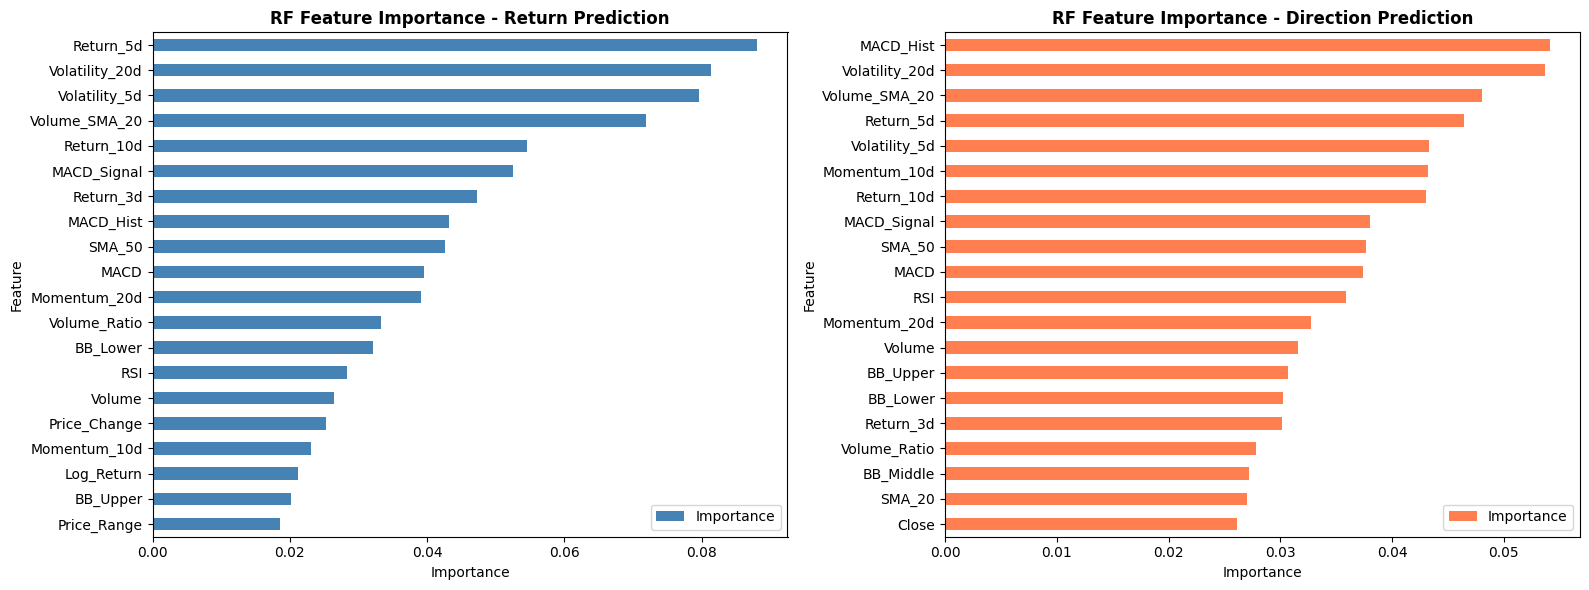

In [6]:
# Visualize RF feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Return prediction importance
rf_importance_reg.head(20).plot(kind='barh', x='Feature', y='Importance', ax=axes[0], color='steelblue')
axes[0].set_title('RF Feature Importance - Return Prediction', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Importance')
axes[0].invert_yaxis()

# Direction prediction importance
rf_importance_clf.head(20).plot(kind='barh', x='Feature', y='Importance', ax=axes[1], color='coral')
axes[1].set_title('RF Feature Importance - Direction Prediction', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

### 2.2 Permutation Importance

In [7]:
print("Calculating permutation importance (this may take a few minutes)...")

# Permutation importance for regression
perm_importance_reg = permutation_importance(
    rf_reg, X_test_last, y_return_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Permutation importance for classification
perm_importance_clf = permutation_importance(
    rf_clf, X_test_last, y_dir_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Create dataframes
perm_df_reg = pd.DataFrame({
    'Feature': FEATURE_NAMES,
    'Importance': perm_importance_reg.importances_mean,
    'Std': perm_importance_reg.importances_std
}).sort_values('Importance', ascending=False)

perm_df_clf = pd.DataFrame({
    'Feature': FEATURE_NAMES,
    'Importance': perm_importance_clf.importances_mean,
    'Std': perm_importance_clf.importances_std
}).sort_values('Importance', ascending=False)

print("\nTop 15 Features (Permutation Importance - Return):")
print(perm_df_reg.head(15))

print("\nTop 15 Features (Permutation Importance - Direction):")
print(perm_df_clf.head(15))

Calculating permutation importance (this may take a few minutes)...

Top 15 Features (Permutation Importance - Return):
          Feature  Importance       Std
28  Volatility_5d    0.020943  0.001271
25      Return_5d    0.020913  0.001808
14      MACD_Hist    0.016801  0.002734
13    MACD_Signal    0.006719  0.001031
24      Return_3d    0.006464  0.001246
31   Momentum_20d    0.005604  0.000576
26     Return_10d    0.005361  0.001351
19  Volume_SMA_20    0.005141  0.001814
12           MACD    0.004621  0.000468
15            RSI    0.003120  0.000449
18       BB_Lower    0.002826  0.000573
20   Volume_Ratio    0.002453  0.000450
9          SMA_50    0.002187  0.000964
23   Price_Change    0.001608  0.000882
22    Price_Range    0.001435  0.000426

Top 15 Features (Permutation Importance - Direction):
           Feature  Importance       Std
25       Return_5d    0.008684  0.001820
29  Volatility_20d    0.004526  0.002822
14       MACD_Hist    0.002987  0.002347
28   Volatility_5d   

### 2.3 Correlation Analysis


Highly Correlated Feature Pairs (|correlation| > 0.9):
  Open <-> High: 0.9999
  Open <-> Low: 0.9999
  Open <-> Close: 0.9999
  Open <-> SMA_5: 0.9999
  Open <-> SMA_10: 0.9997
  Open <-> SMA_20: 0.9992
  Open <-> SMA_50: 0.9979
  Open <-> EMA_12: 0.9997
  Open <-> EMA_26: 0.9992
  Open <-> BB_Middle: 0.9992
  Open <-> BB_Upper: 0.9991
  Open <-> BB_Lower: 0.9985
  High <-> Low: 0.9999
  High <-> Close: 0.9999
  High <-> SMA_5: 0.9999
  High <-> SMA_10: 0.9996
  High <-> SMA_20: 0.9991
  High <-> SMA_50: 0.9978
  High <-> EMA_12: 0.9997
  High <-> EMA_26: 0.9992
  High <-> BB_Middle: 0.9991
  High <-> BB_Upper: 0.9990
  High <-> BB_Lower: 0.9984
  Low <-> Close: 0.9999
  Low <-> SMA_5: 0.9999
  Low <-> SMA_10: 0.9996
  Low <-> SMA_20: 0.9992
  Low <-> SMA_50: 0.9978
  Low <-> EMA_12: 0.9997
  Low <-> EMA_26: 0.9992
  Low <-> BB_Middle: 0.9992
  Low <-> BB_Upper: 0.9990
  Low <-> BB_Lower: 0.9985
  Close <-> SMA_5: 0.9998
  Close <-> SMA_10: 0.9996
  Close <-> SMA_20: 0.9991
  Close <

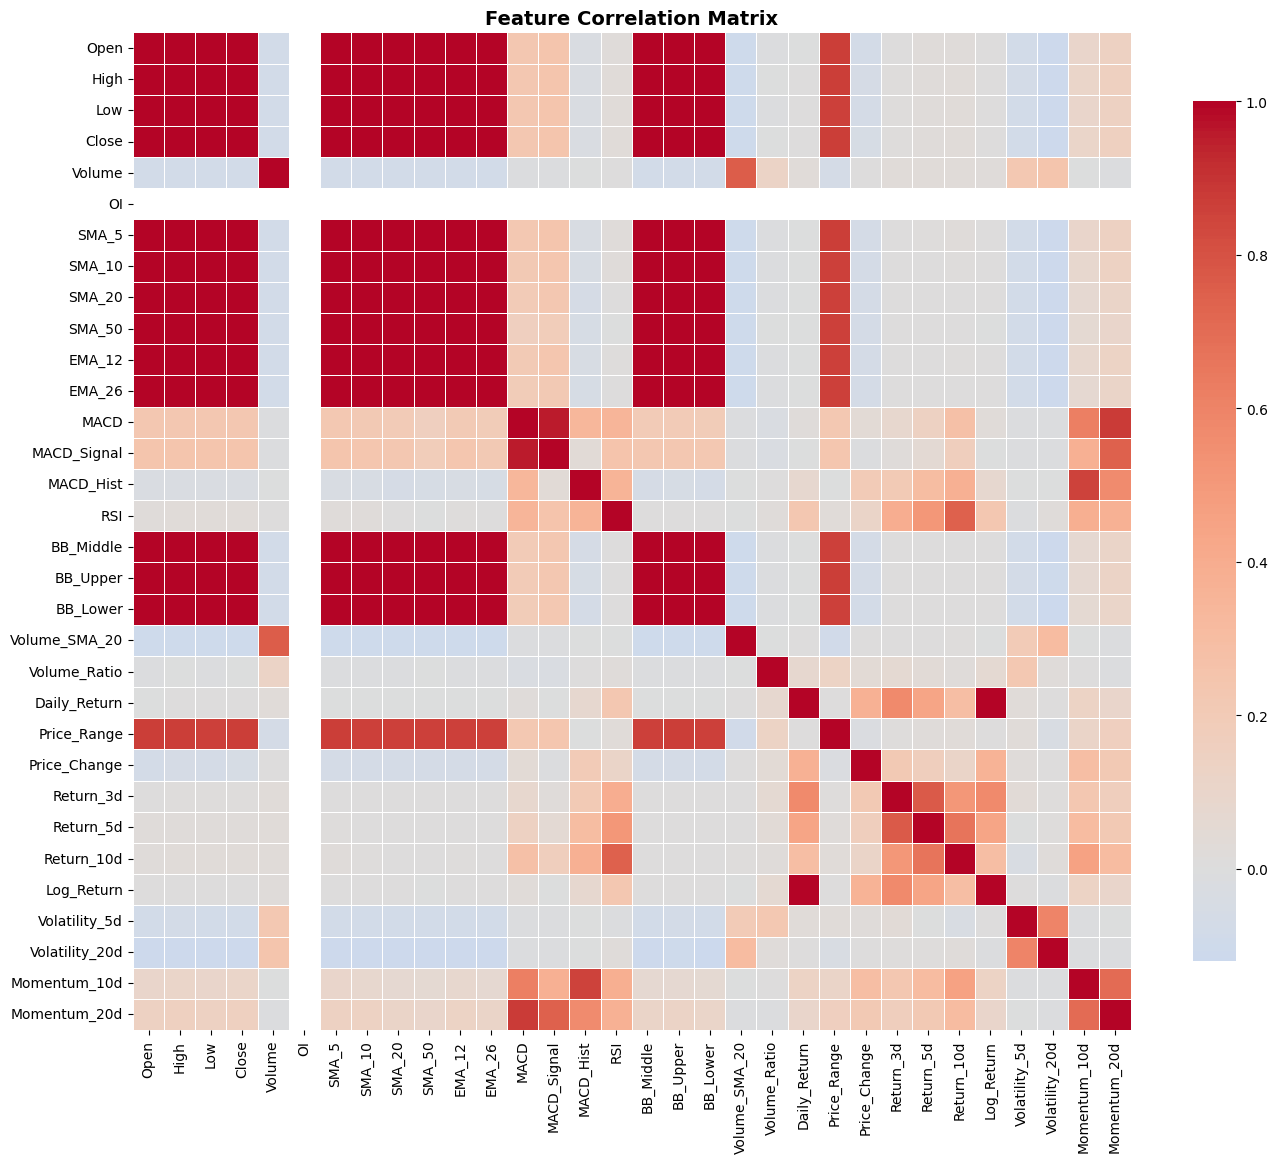

In [8]:
# Calculate correlation matrix
corr_matrix = pd.DataFrame(X_train_last, columns=FEATURE_NAMES).corr()

# Find highly correlated features (>0.9)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

print(f"\nHighly Correlated Feature Pairs (|correlation| > 0.9):")
for feat1, feat2, corr in high_corr_pairs:
    print(f"  {feat1} <-> {feat2}: {corr:.4f}")

# Visualize correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.4 Mutual Information

In [9]:
print("Calculating mutual information...")

# Mutual information for regression
mi_reg = mutual_info_regression(X_train_last, y_return_train, random_state=42)
mi_df_reg = pd.DataFrame({
    'Feature': FEATURE_NAMES,
    'MI_Score': mi_reg
}).sort_values('MI_Score', ascending=False)

# Mutual information for classification
mi_clf = mutual_info_classif(X_train_last, y_dir_train, random_state=42)
mi_df_clf = pd.DataFrame({
    'Feature': FEATURE_NAMES,
    'MI_Score': mi_clf
}).sort_values('MI_Score', ascending=False)

print("\nTop 15 Features (Mutual Information - Return):")
print(mi_df_reg.head(15))

print("\nTop 15 Features (Mutual Information - Direction):")
print(mi_df_clf.head(15))

Calculating mutual information...

Top 15 Features (Mutual Information - Return):
           Feature  MI_Score
3            Close  0.043476
11          EMA_26  0.042899
10          EMA_12  0.041468
9           SMA_50  0.041242
18        BB_Lower  0.040954
8           SMA_20  0.039763
16       BB_Middle  0.039762
6            SMA_5  0.039410
2              Low  0.038571
1             High  0.038529
7           SMA_10  0.037757
17        BB_Upper  0.035125
0             Open  0.033724
29  Volatility_20d  0.027985
13     MACD_Signal  0.017150

Top 15 Features (Mutual Information - Direction):
           Feature  MI_Score
17        BB_Upper  0.044299
18        BB_Lower  0.039166
11          EMA_26  0.031116
8           SMA_20  0.029664
16       BB_Middle  0.029640
9           SMA_50  0.028276
10          EMA_12  0.024333
7           SMA_10  0.019697
1             High  0.017005
6            SMA_5  0.014266
2              Low  0.011786
29  Volatility_20d  0.011137
3            Close  0.0110

### 2.5 SHAP Values (if available)

Calculating SHAP values (this may take several minutes)...

Top 15 Features (SHAP - Return Prediction):
           Feature  SHAP_Importance
25       Return_5d         0.320823
26      Return_10d         0.104064
29  Volatility_20d         0.099514
14       MACD_Hist         0.099460
28   Volatility_5d         0.098396
31    Momentum_20d         0.050626
18        BB_Lower         0.050152
15             RSI         0.044919
9           SMA_50         0.044770
30    Momentum_10d         0.044117
22     Price_Range         0.037337
19   Volume_SMA_20         0.036119
13     MACD_Signal         0.034736
24       Return_3d         0.027013
12            MACD         0.021310


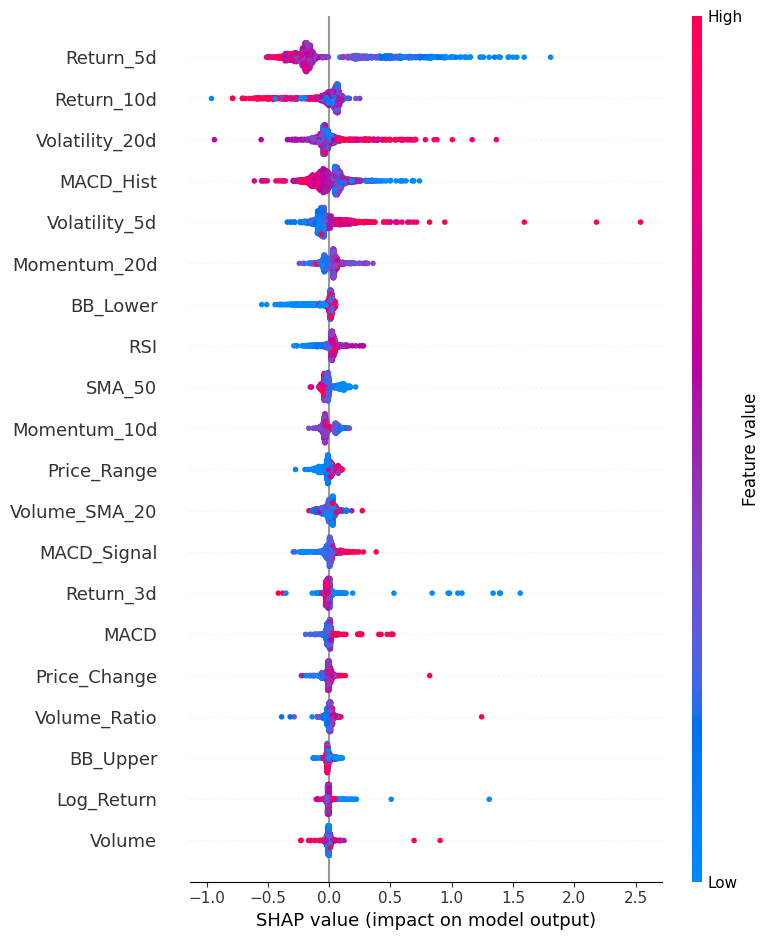

In [10]:
if SHAP_AVAILABLE:
    print("Calculating SHAP values (this may take several minutes)...")
    
    # Use a subset for faster computation
    sample_size = min(1000, len(X_train_last))
    X_sample = X_train_last[:sample_size]
    
    # SHAP for regression
    explainer_reg = shap.TreeExplainer(rf_reg)
    shap_values_reg = explainer_reg.shap_values(X_sample)
    
    # Feature importance from SHAP
    shap_importance_reg = pd.DataFrame({
        'Feature': FEATURE_NAMES,
        'SHAP_Importance': np.abs(shap_values_reg).mean(axis=0)
    }).sort_values('SHAP_Importance', ascending=False)
    
    print("\nTop 15 Features (SHAP - Return Prediction):")
    print(shap_importance_reg.head(15))
    
    # SHAP summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_reg, X_sample, feature_names=FEATURE_NAMES, show=False)
    plt.tight_layout()
    plt.show()
else:
    print("\nSHAP analysis skipped. Install with 'uv add shap' to enable.")
    shap_importance_reg = None

## 3. Feature Selection Methods

### 3.1 Recursive Feature Elimination (RFE)

In [11]:
print(f"Running RFE to select top {TARGET_N_FEATURES} features...")

# RFE for regression
rfe_reg = RFE(estimator=LinearRegression(), n_features_to_select=TARGET_N_FEATURES)
rfe_reg.fit(X_train_last, y_return_train)

# RFE for classification
rfe_clf = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=TARGET_N_FEATURES)
rfe_clf.fit(X_train_last, y_dir_train)

# Selected features
rfe_features_reg = [FEATURE_NAMES[i] for i, selected in enumerate(rfe_reg.support_) if selected]
rfe_features_clf = [FEATURE_NAMES[i] for i, selected in enumerate(rfe_clf.support_) if selected]

print(f"\nRFE Selected Features (Return Prediction):")
print(rfe_features_reg)

print(f"\nRFE Selected Features (Direction Prediction):")
print(rfe_features_clf)

Running RFE to select top 15 features...

RFE Selected Features (Return Prediction):
['Open', 'High', 'Low', 'Close', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD_Hist', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'Return_5d']

RFE Selected Features (Direction Prediction):
['Volume', 'SMA_10', 'SMA_50', 'MACD', 'MACD_Signal', 'MACD_Hist', 'RSI', 'BB_Upper', 'BB_Lower', 'Volume_Ratio', 'Daily_Return', 'Return_5d', 'Return_10d', 'Volatility_5d', 'Momentum_20d']


### 3.2 L1 Regularization (Lasso)

In [12]:
print("Training Lasso with cross-validation...")

# Lasso with CV to find optimal alpha
lasso_cv = LassoCV(cv=5, random_state=42, n_jobs=-1)
lasso_cv.fit(X_train_last, y_return_train)

print(f"Optimal alpha: {lasso_cv.alpha_:.6f}")

# Feature coefficients
lasso_coefs = pd.DataFrame({
    'Feature': FEATURE_NAMES,
    'Coefficient': np.abs(lasso_cv.coef_)
}).sort_values('Coefficient', ascending=False)

# Select non-zero features
lasso_selected = lasso_coefs[lasso_coefs['Coefficient'] > 0]

print(f"\nLasso selected {len(lasso_selected)} features:")
print(lasso_selected)

# If more than target, take top N
lasso_top_features = lasso_coefs.head(TARGET_N_FEATURES)['Feature'].tolist()
print(f"\nTop {TARGET_N_FEATURES} Lasso Features:")
print(lasso_top_features)

Training Lasso with cross-validation...
Optimal alpha: 0.065079

Lasso selected 5 features:
          Feature  Coefficient
25      Return_5d     0.324833
28  Volatility_5d     0.223567
26     Return_10d     0.069370
20   Volume_Ratio     0.050047
24      Return_3d     0.042363

Top 15 Lasso Features:
['Return_5d', 'Volatility_5d', 'Return_10d', 'Volume_Ratio', 'Return_3d', 'Open', 'Low', 'High', 'SMA_20', 'SMA_50', 'EMA_12', 'Close', 'Volume', 'OI', 'SMA_5']


## 4. Consensus Feature Selection

In [13]:
# Combine all methods to find consensus
feature_rankings = {}

# Method 1: RF Importance (average of reg and clf)
for idx, row in rf_importance_reg.iterrows():
    feature = row['Feature']
    rank_reg = idx + 1
    rank_clf = rf_importance_clf[rf_importance_clf['Feature'] == feature].index[0] + 1
    feature_rankings.setdefault(feature, []).append((rank_reg + rank_clf) / 2)

# Method 2: Permutation Importance
for idx, row in perm_df_reg.iterrows():
    feature = row['Feature']
    rank_reg = idx + 1
    rank_clf = perm_df_clf[perm_df_clf['Feature'] == feature].index[0] + 1
    feature_rankings.setdefault(feature, []).append((rank_reg + rank_clf) / 2)

# Method 3: Mutual Information
for idx, row in mi_df_reg.iterrows():
    feature = row['Feature']
    rank_reg = idx + 1
    rank_clf = mi_df_clf[mi_df_clf['Feature'] == feature].index[0] + 1
    feature_rankings.setdefault(feature, []).append((rank_reg + rank_clf) / 2)

# Method 4: RFE
for feature in FEATURE_NAMES:
    rank = 1 if feature in rfe_features_reg or feature in rfe_features_clf else len(FEATURE_NAMES)
    feature_rankings.setdefault(feature, []).append(rank)

# Method 5: Lasso
for idx, row in lasso_coefs.iterrows():
    feature = row['Feature']
    feature_rankings.setdefault(feature, []).append(idx + 1)

# Calculate average rank
consensus_ranking = pd.DataFrame([
    {'Feature': feature, 'Average_Rank': np.mean(ranks)}
    for feature, ranks in feature_rankings.items()
]).sort_values('Average_Rank')

# Select top N features
SELECTED_FEATURES = consensus_ranking.head(TARGET_N_FEATURES)['Feature'].tolist()

print("\n" + "="*80)
print(f"CONSENSUS TOP {TARGET_N_FEATURES} FEATURES")
print("="*80)
print(consensus_ranking.head(TARGET_N_FEATURES))
print("\nSelected Features:")
for i, feat in enumerate(SELECTED_FEATURES, 1):
    print(f"{i:2d}. {feat}")


CONSENSUS TOP 15 FEATURES
        Feature  Average_Rank
23         Open           1.0
27         High           1.8
25          Low           2.6
22        Close           3.4
14       Volume           4.2
28        SMA_5           5.8
26       SMA_10           6.6
24       SMA_20           7.4
8        SMA_50           8.2
30       EMA_12           9.0
20       EMA_26           9.8
9          MACD          10.6
31           OI          11.2
5   MACD_Signal          11.4
7     MACD_Hist          12.2

Selected Features:
 1. Open
 2. High
 3. Low
 4. Close
 5. Volume
 6. SMA_5
 7. SMA_10
 8. SMA_20
 9. SMA_50
10. EMA_12
11. EMA_26
12. MACD
13. OI
14. MACD_Signal
15. MACD_Hist


## 5. Model Performance Comparison (32 vs 15 Features)

In [14]:
# Get feature indices
selected_indices = [FEATURE_NAMES.index(f) for f in SELECTED_FEATURES]

# Create reduced datasets
X_train_reduced = X_train_scaled[:, :, selected_indices]
X_test_reduced = X_test_scaled[:, :, selected_indices]

X_train_reduced_flat = X_train_reduced.reshape(n_samples_train, -1)
X_test_reduced_flat = X_test_reduced.reshape(n_samples_test, -1)

X_train_reduced_last = X_train_reduced[:, -1, :]
X_test_reduced_last = X_test_reduced[:, -1, :]

print(f"\nReduced feature shape: {X_train_reduced.shape}")
print(f"Original feature shape: {X_train_scaled.shape}")


Reduced feature shape: (29640, 60, 15)
Original feature shape: (29640, 60, 32)


### 5.1 Linear Models Comparison

In [15]:
def evaluate_linear_models(X_train, X_test, y_return_train, y_dir_train, y_return_test, y_dir_test, name):
    """Train and evaluate linear models."""
    start_time = time.time()
    
    # Train
    lr = LinearRegression()
    lr.fit(X_train, y_return_train)
    
    log_reg = LogisticRegression(max_iter=1000, random_state=42)
    log_reg.fit(X_train, y_dir_train)
    
    train_time = time.time() - start_time
    
    # Predict
    y_return_pred = lr.predict(X_test)
    y_dir_pred = log_reg.predict(X_test)
    
    # Metrics
    mae = mean_absolute_error(y_return_test, y_return_pred)
    accuracy = accuracy_score(y_dir_test, y_dir_pred)
    f1 = f1_score(y_dir_test, y_dir_pred)
    
    return {
        'Name': name,
        'MAE': mae,
        'Accuracy': accuracy,
        'F1': f1,
        'Train Time': train_time
    }

# Compare 32 vs 15 features
results_32 = evaluate_linear_models(
    X_train_flat, X_test_flat,
    y_return_train, y_dir_train, y_return_test, y_dir_test,
    "Linear (32 features)"
)

results_15 = evaluate_linear_models(
    X_train_reduced_flat, X_test_reduced_flat,
    y_return_train, y_dir_train, y_return_test, y_dir_test,
    "Linear (15 features)"
)

print("\n" + "="*80)
print("LINEAR MODELS: 32 vs 15 FEATURES")
print("="*80)
comparison_linear = pd.DataFrame([results_32, results_15])
print(comparison_linear.to_string(index=False))


LINEAR MODELS: 32 vs 15 FEATURES
                Name      MAE  Accuracy       F1  Train Time
Linear (32 features) 3.491661  0.594605 0.621266  173.912221
Linear (15 features) 3.605225  0.551447 0.668095  102.025250


### 5.2 LSTM Models Comparison

In [16]:
def train_lstm(X_train, X_test, y_return_train, y_dir_train, y_return_test, y_dir_test, name):
    """Train and evaluate LSTM model."""
    start_time = time.time()
    
    n_feats = X_train.shape[2]
    
    # Build model
    inputs = layers.Input(shape=(WINDOW_SIZE, n_feats))
    x = layers.LSTM(128, return_sequences=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    
    return_output = layers.Dense(1, name='return')(x)
    direction_output = layers.Dense(1, activation='sigmoid', name='direction')(x)
    
    model = models.Model(inputs=inputs, outputs=[return_output, direction_output])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss={'return': 'mse', 'direction': 'binary_crossentropy'},
        loss_weights={'return': 1.0, 'direction': 1.0},
        metrics={'direction': 'accuracy'}
    )
    
    # Train
    model.fit(
        X_train,
        {'return': y_return_train, 'direction': y_dir_train},
        validation_split=0.2,
        epochs=50,
        batch_size=64,
        verbose=0,
        callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
    )
    
    train_time = time.time() - start_time
    
    # Predict
    y_return_pred, y_dir_pred = model.predict(X_test, verbose=0)
    y_return_pred = y_return_pred.flatten()
    y_dir_pred = (y_dir_pred.flatten() > 0.5).astype(int)
    
    # Metrics
    mae = mean_absolute_error(y_return_test, y_return_pred)
    accuracy = accuracy_score(y_dir_test, y_dir_pred)
    f1 = f1_score(y_dir_test, y_dir_pred)
    
    return {
        'Name': name,
        'MAE': mae,
        'Accuracy': accuracy,
        'F1': f1,
        'Train Time': train_time
    }

# Compare 32 vs 15 features
print("Training LSTM with 32 features...")
lstm_results_32 = train_lstm(
    X_train_scaled, X_test_scaled,
    y_return_train, y_dir_train, y_return_test, y_dir_test,
    "LSTM (32 features)"
)

print("Training LSTM with 15 features...")
lstm_results_15 = train_lstm(
    X_train_reduced, X_test_reduced,
    y_return_train, y_dir_train, y_return_test, y_dir_test,
    "LSTM (15 features)"
)

print("\n" + "="*80)
print("LSTM MODELS: 32 vs 15 FEATURES")
print("="*80)
comparison_lstm = pd.DataFrame([lstm_results_32, lstm_results_15])
print(comparison_lstm.to_string(index=False))

Training LSTM with 32 features...


2025-11-14 22:49:41.426323: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-11-14 22:49:48.297122: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 182108160 exceeds 10% of free system memory.


Training LSTM with 15 features...

LSTM MODELS: 32 vs 15 FEATURES
              Name      MAE  Accuracy       F1  Train Time
LSTM (32 features) 3.568980  0.543553 0.587956  481.527716
LSTM (15 features) 3.613179  0.526842 0.592198  552.068392


## 6. Final Results Summary

In [17]:
# Combine all results
all_results = pd.DataFrame([
    results_32, results_15,
    lstm_results_32, lstm_results_15
])

print("\n" + "="*80)
print("FEATURE SELECTION - FINAL COMPARISON")
print("="*80)
print(all_results.to_string(index=False))

# Calculate improvements
print("\n" + "="*80)
print("IMPROVEMENTS FROM FEATURE REDUCTION (32 → 15)")
print("="*80)

for model_type in ['Linear', 'LSTM']:
    r32 = all_results[all_results['Name'].str.contains(f"{model_type} \(32")].iloc[0]
    r15 = all_results[all_results['Name'].str.contains(f"{model_type} \(15")].iloc[0]
    
    print(f"\n{model_type} Models:")
    print(f"  MAE: {r32['MAE']:.4f} → {r15['MAE']:.4f} ({((r15['MAE']-r32['MAE'])/r32['MAE']*100):+.2f}%)")
    print(f"  Accuracy: {r32['Accuracy']:.4f} → {r15['Accuracy']:.4f} ({((r15['Accuracy']-r32['Accuracy'])/r32['Accuracy']*100):+.2f}%)")
    print(f"  F1 Score: {r32['F1']:.4f} → {r15['F1']:.4f} ({((r15['F1']-r32['F1'])/r32['F1']*100):+.2f}%)")
    print(f"  Train Time: {r32['Train Time']:.2f}s → {r15['Train Time']:.2f}s ({((r15['Train Time']-r32['Train Time'])/r32['Train Time']*100):+.2f}%)")


FEATURE SELECTION - FINAL COMPARISON
                Name      MAE  Accuracy       F1  Train Time
Linear (32 features) 3.491661  0.594605 0.621266  173.912221
Linear (15 features) 3.605225  0.551447 0.668095  102.025250
  LSTM (32 features) 3.568980  0.543553 0.587956  481.527716
  LSTM (15 features) 3.613179  0.526842 0.592198  552.068392

IMPROVEMENTS FROM FEATURE REDUCTION (32 → 15)

Linear Models:
  MAE: 3.4917 → 3.6052 (+3.25%)
  Accuracy: 0.5946 → 0.5514 (-7.26%)
  F1 Score: 0.6213 → 0.6681 (+7.54%)
  Train Time: 173.91s → 102.03s (-41.34%)

LSTM Models:
  MAE: 3.5690 → 3.6132 (+1.24%)
  Accuracy: 0.5436 → 0.5268 (-3.07%)
  F1 Score: 0.5880 → 0.5922 (+0.72%)
  Train Time: 481.53s → 552.07s (+14.65%)


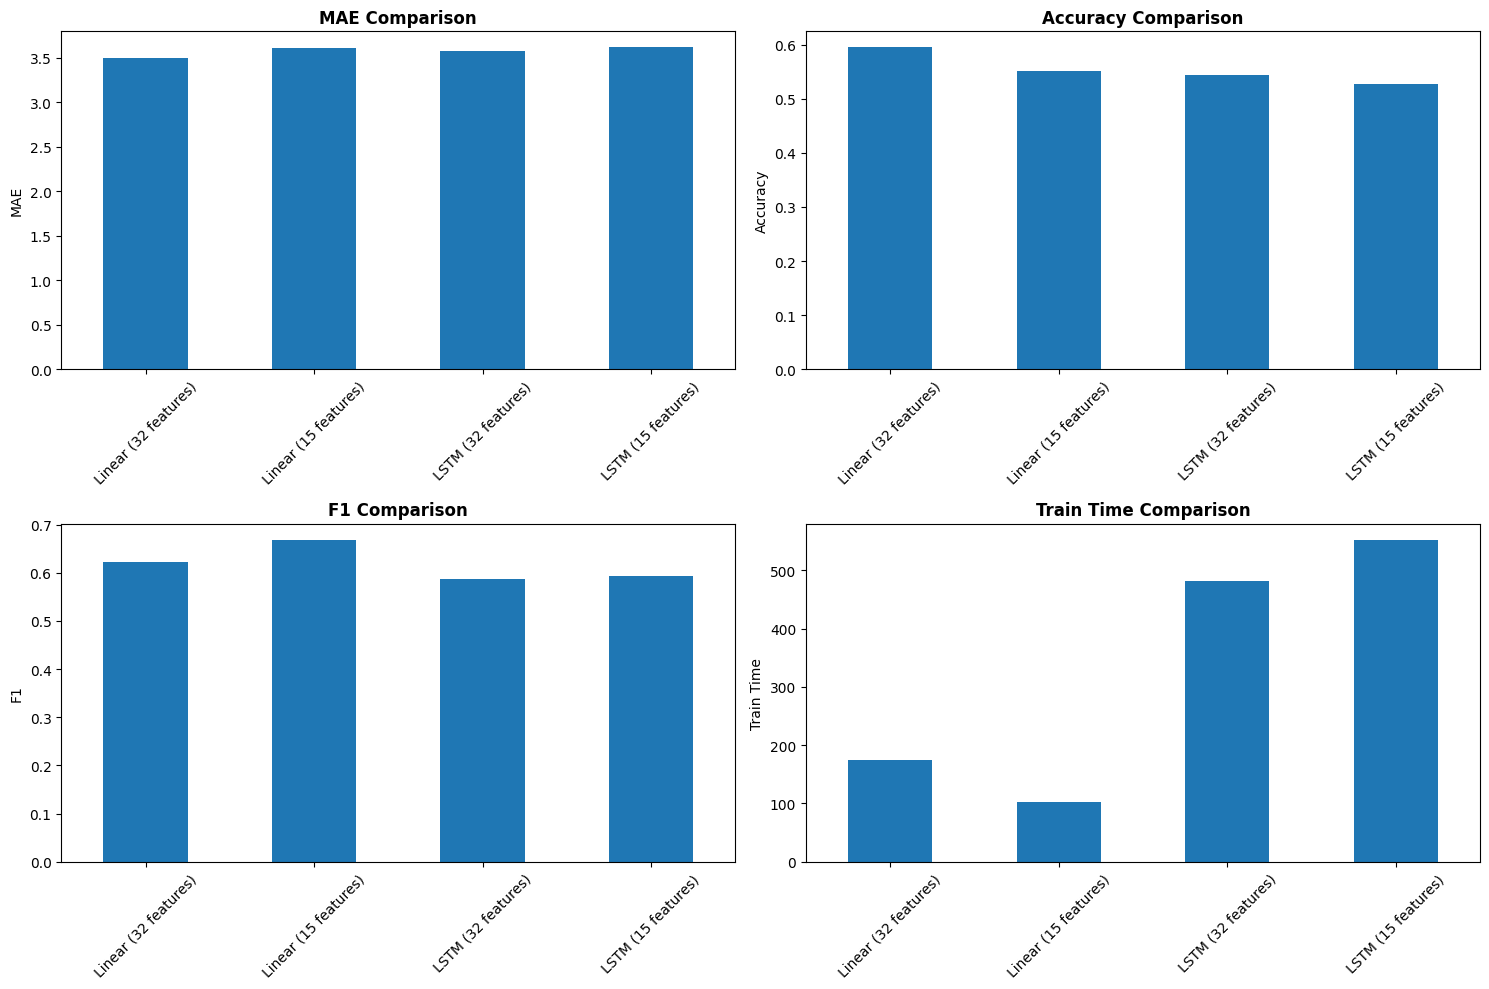

In [18]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['MAE', 'Accuracy', 'F1', 'Train Time']
for idx, metric in enumerate(metrics):
    row, col = idx // 2, idx % 2
    all_results.plot(kind='bar', x='Name', y=metric, ax=axes[row, col], legend=False)
    axes[row, col].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel(metric)
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Save Selected Features

In [20]:
# Save selected features to file
output_path = Path('data/processed/selected_features.txt')
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, 'w') as f:
    f.write(f"Top {TARGET_N_FEATURES} Selected Features\n")
    f.write("="*50 + "\n\n")
    for i, feat in enumerate(SELECTED_FEATURES, 1):
        f.write(f"{i:2d}. {feat}\n")

print(f"\nSelected features saved to: {output_path}")

# Also save as Python list for easy import
print("\nPython list (for easy copy-paste):")
print("SELECTED_FEATURES = [")
for feat in SELECTED_FEATURES:
    print(f"    '{feat}',")
print("]")


Selected features saved to: data/processed/selected_features.txt

Python list (for easy copy-paste):
SELECTED_FEATURES = [
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'SMA_5',
    'SMA_10',
    'SMA_20',
    'SMA_50',
    'EMA_12',
    'EMA_26',
    'MACD',
    'OI',
    'MACD_Signal',
    'MACD_Hist',
]


## 8. MLflow Logging

In [21]:
# Setup MLflow
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

# Log results
for _, row in all_results.iterrows():
    with mlflow.start_run(run_name=row['Name']):
        mlflow.log_param('model_type', row['Name'])
        mlflow.log_param('n_features', 15 if '15' in row['Name'] else 32)
        mlflow.log_param('window_size', WINDOW_SIZE)
        mlflow.log_param('horizon', HORIZON)
        
        mlflow.log_metric('mae', row['MAE'])
        mlflow.log_metric('accuracy', row['Accuracy'])
        mlflow.log_metric('f1_score', row['F1'])
        mlflow.log_metric('train_time', row['Train Time'])

print("\nAll results logged to MLflow!")

2025/11/14 23:10:36 INFO mlflow.tracking.fluent: Experiment with name 'stock-feature-selection' does not exist. Creating a new experiment.



All results logged to MLflow!


## 9. Conclusions

### Key Findings:

### Selected Features:

### Recommendations:

### Next Steps:
